# Reading 15 million reviews 

*what is the best way to read 15 million reviews?* 

In [1]:
import gzip
import json
import os

import pandas as pd

In [2]:
DIR = "./data"

In [3]:
def load_data(file_name, head=100):
    # 15739967
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            
            # only get review_text and review_stars
            data.append([d['review_text'], d['n_votes'], d['rating']])


            # break if reaches the headth line
            if (head is not None) and (count > head):
                break
    return data

In [4]:
reviews = pd.DataFrame(load_data(os.path.join(
    DIR, "goodreads_reviews_dedup.json.gz"))
)

# rename columns: reviews_text, n_votes, rating
reviews.columns = ['review_text', 'n_votes', 'rating']

FileNotFoundError: [Errno 2] No such file or directory: './data/goodreads_reviews_dedup.json.gz'

In [ ]:
reviews

,review_text,n_votes,rating
0,Mind blowingly cool. Best science fiction I've...,16,5
1,This is a special book. It started slow for ab...,28,5
2,I haven't read a fun mystery book in a while a...,6,3
3,"Fun, fast paced, and disturbing tale of murder...",22,4
4,A fun book that gives you a sense of living in...,8,4
...,...,...,...
96,The Name of the Rose is a thrilling Dan Brown-...,17,3
97,An extremely well-written account of the 2008 ...,16,5
98,** spoiler alert ** \n An interesting book in ...,7,4
99,This is a book that every entrepreneur definit...,33,5


In [ ]:
reviews.to_csv(os.path.join(DIR, "tinysample.csv"), index=False)

# EDA

In [5]:
import nltk

from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet

import string

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [6]:
nltk.download('opinion_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jessedoka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

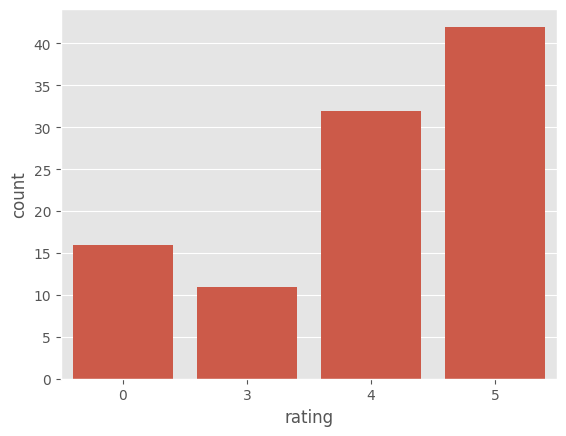

In [ ]:
ax = sns.countplot(data=reviews, x='rating')

In [ ]:
example = reviews.iloc[55]['review_text']
print(example)

A wonderful, beautifully written, poignant, subtle, and brilliant novel. 
 This is the story of an English butler of one the great houses, whose self value comes from his duty and his dignity, and who questions his values and his life in the end. It is ultimately a story of regret. It is a story that makes you want to live your life and dedicate yourself to things that you won't regret when you look back. One of the best ways of thinking about regret I've ever come across is from Jeff Bezos in his nerdily titled Regret Minimization Framework. 
 But what I really loved about the novel is how slow and forcefully it builds. I don't think I've read a book that does that so well since Pride and Prejudice. In the beginning you think it's just a butler going on a motoring trip. And at the end, your heart is breaking. 
 Dignity is a big theme in the novel. Stevens attempts to define dignity several times throughout the novel - his definition generally has to do with self-respect and keeping on

In [ ]:
sentences = sent_tokenize(example)
sentences

['A wonderful, beautifully written, poignant, subtle, and brilliant novel.',
 'This is the story of an English butler of one the great houses, whose self value comes from his duty and his dignity, and who questions his values and his life in the end.',
 'It is ultimately a story of regret.',
 "It is a story that makes you want to live your life and dedicate yourself to things that you won't regret when you look back.",
 "One of the best ways of thinking about regret I've ever come across is from Jeff Bezos in his nerdily titled Regret Minimization Framework.",
 'But what I really loved about the novel is how slow and forcefully it builds.',
 "I don't think I've read a book that does that so well since Pride and Prejudice.",
 "In the beginning you think it's just a butler going on a motoring trip.",
 'And at the end, your heart is breaking.',
 'Dignity is a big theme in the novel.',
 'Stevens attempts to define dignity several times throughout the novel - his definition generally has to

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def extract_sentiment_terms(sentence):
    # Tokenize words and tag part of speech
    words = word_tokenize(sentence)
    tagged_words = pos_tag(words)
    sentiment_terms = set()

    for word, tag in tagged_words:
        if word.lower() not in stop_words and word not in string.punctuation:
            if tag.startswith('JJ') or tag.startswith('RB'):
                if word.lower() in opinion_lexicon.positive() or word.lower() in opinion_lexicon.negative():
                    sentiment_terms.add(word)

    return sentiment_terms


In [ ]:
sentiment_terms = set()
for sentence in sentences:
    sentiment_terms.update(extract_sentiment_terms(sentence))

In [ ]:
sentiment_terms

{'Good',
 'beautifully',
 'best',
 'better',
 'brilliant',
 'favorite',
 'fond',
 'great',
 'hard',
 'interesting',
 'poignant',
 'self-respect',
 'slow',
 'well',
 'wonderful'}

In [ ]:
from gensim.models import Word2Vec
import networkx as nx

In [ ]:
# get all sentiement terms from all reviews
sentiment_terms = set()
for review in reviews['review_text']:
    sentences = sent_tokenize(review)
    for sentence in sentences:
        sentiment_terms.update(extract_sentiment_terms(sentence))

In [ ]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

In [ ]:
def learn_word_embeddings(processed_corpus):
    # Train a Word2Vec model on the processed corpus
    model = Word2Vec(sentences=processed_corpus,
                     vector_size=100, window=5, min_count=1, workers=4)
    return model       

In [ ]:
model = learn_word_embeddings([word_tokenize(word) for word in sentiment_terms])

token = 'amazing'

if token in model.wv:
    print(f"{token}: {model.wv.most_similar(token)}")
else:
    synonyms = get_synonyms(token)

    for synonym in synonyms:
        if synonym in model.wv:
            print(f"{synonym}: {model.wv.most_similar(synonym)}")

amazing: [('striking', 0.25589990615844727), ('useful', 0.2530410885810852), ('risky', 0.2439536303281784), ('mind-blowing', 0.211429163813591), ('stupidly', 0.20832671225070953), ('instantly', 0.1980828493833542), ('loyal', 0.1907116025686264), ('hostile', 0.18993185460567474), ('damned', 0.1869504153728485), ('Pretty', 0.18673360347747803)]
